In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed dataset
file_path = "processed_UNSW_NB15_cleaned.csv"  # Update with your file path
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Overview:")
print(df.head())

print("\nDataset Info:")
print(df.info())


Dataset Overview:
        dur  spkts  dpkts  sbytes  dbytes       rate        sload  dload  \
0  0.000011      2      0     496       0   90909.09  180363630.0    0.0   
1  0.000008      2      0    1762       0  125000.00  881000000.0    0.0   
2  0.000005      2      0    1068       0  200000.00  854400000.0    0.0   
3  0.000006      2      0     900       0  166666.66  600000000.0    0.0   
4  0.000010      2      0    2126       0  100000.00  850400000.0    0.0   

   sloss  dloss  ...  state_no  attack_cat_Backdoor  attack_cat_DoS  \
0      0      0  ...       0.0                  0.0             0.0   
1      0      0  ...       0.0                  0.0             0.0   
2      0      0  ...       0.0                  0.0             0.0   
3      0      0  ...       0.0                  0.0             0.0   
4      0      0  ...       0.0                  0.0             0.0   

   attack_cat_Exploits  attack_cat_Fuzzers  attack_cat_Generic  \
0                  0.0          

In [35]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
print("Categorical Columns:", categorical_cols)

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_data = encoder.fit_transform(df[categorical_cols])

# Convert encoded data to DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and merge encoded data
df = df.drop(categorical_cols, axis=1)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("\nCategorical Features Encoded Successfully!")



print(df.dtypes)

Categorical Columns: Index([], dtype='object')

Categorical Features Encoded Successfully!
dur                          float64
spkts                          int64
dpkts                          int64
sbytes                         int64
dbytes                         int64
                              ...   
attack_cat_Generic           float64
attack_cat_Normal            float64
attack_cat_Reconnaissance    float64
attack_cat_Shellcode         float64
attack_cat_Worms             float64
Length: 195, dtype: object


In [36]:
df.to_csv("processed_UNSW_NB15_cleaned.csv", index=False)
print("\nPreprocessed dataset saved as processed_UNSW_NB15_cleaned.csv")



Preprocessed dataset saved as processed_UNSW_NB15_cleaned.csv


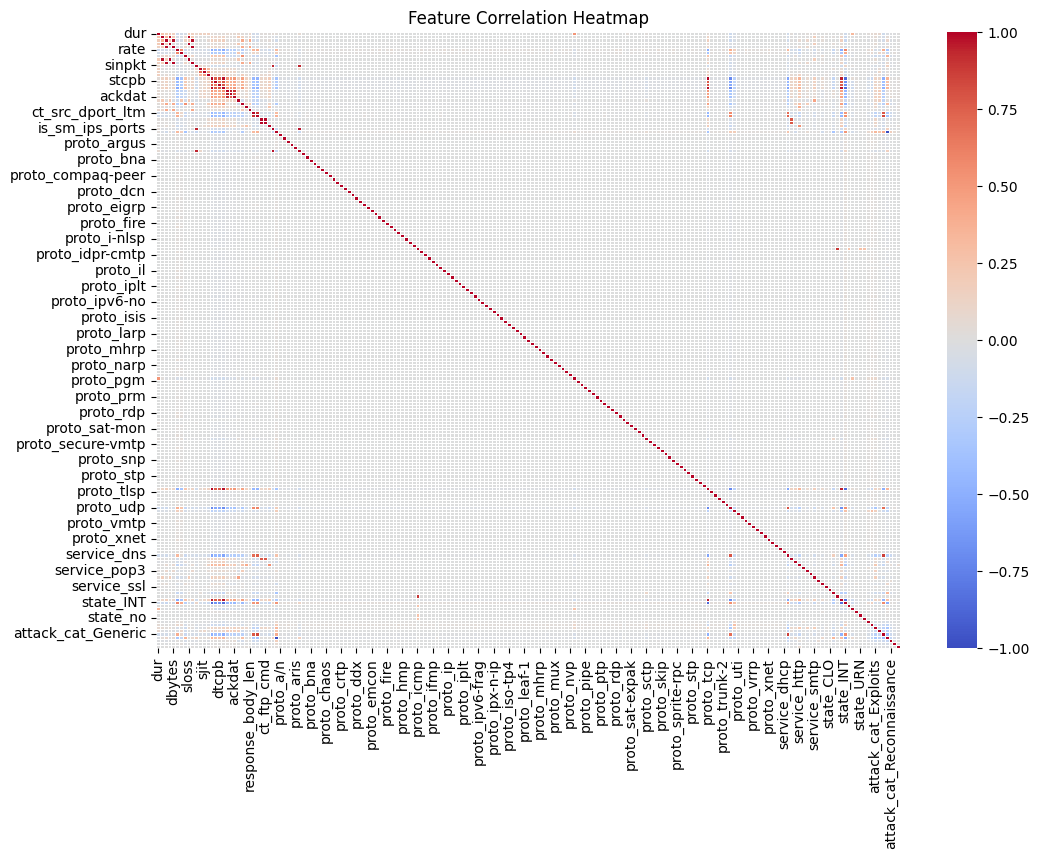

In [37]:
# Compute correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [38]:
from sklearn.model_selection import train_test_split

# Separate Features (X) and Target (y)
X = df.drop("label", axis=1)  # Replace "label" with the actual target column name
y = df["label"]

# Split into 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (206138, 194)
Testing Set Shape: (51535, 194)


In [39]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)  # Traini

# 1. Check feature importances from your decision tree
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

# Show top 10 features and their importance scores
print("Top 10 most important features:")
print(importances.head(10))

# Check for suspiciously high importance (>0.5)
suspicious_features = importances[importances['importance'] > 0.5]
if not suspicious_features.empty:
    print("\nPotentially problematic features (importance > 0.5):")
    print(suspicious_features)

# 2. Check for perfect correlations with target
correlations = []
for column in X_train.columns:
    correlation = abs(pd.Series(y_train).corr(X_train[column]))
    correlations.append({'feature': column, 'correlation': correlation})

corr_df = pd.DataFrame(correlations)
corr_df = corr_df.sort_values('correlation', ascending=False)

print("\nTop 10 features with highest correlation to target:")
print(corr_df.head(10))

# 3. Check for duplicate or nearly identical columns
print("\nChecking for duplicate columns...")
duplicates = X_train.T.duplicated()
if duplicates.any():
    print("Duplicate columns found:", X_train.columns[duplicates].tolist())

# 4. Check for constant or nearly constant features
constant_features = []
for column in X_train.columns:
    if X_train[column].nunique() <= 1:
        constant_features.append(column)
        
print("\nConstant features:", constant_features)

# 5. Print column names to check for suspicious features
print("\nAll feature names (check for target-related names):")
print(X_train.columns.tolist())

Top 10 most important features:
               feature  importance
190  attack_cat_Normal         1.0
0                  dur         0.0
133          proto_smp         0.0
123    proto_sat-expak         0.0
124      proto_sat-mon         0.0
125     proto_sccopmce         0.0
126         proto_scps         0.0
127         proto_sctp         0.0
128         proto_sdrp         0.0
129  proto_secure-vmtp         0.0

Potentially problematic features (importance > 0.5):
               feature  importance
190  attack_cat_Normal         1.0


c:\Users\Ayushman\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Ayushman\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Top 10 features with highest correlation to target:
                 feature  correlation
190    attack_cat_Normal     1.000000
179            state_INT     0.516322
189   attack_cat_Generic     0.408519
26      ct_dst_sport_ltm     0.371033
143            proto_tcp     0.364791
14                  swin     0.364675
7                  dload     0.352482
176            state_CON     0.345270
187  attack_cat_Exploits     0.343036
17                  dwin     0.339693

Checking for duplicate columns...
Duplicate columns found: ['state_PAR']

Constant features: ['state_CLO', 'state_PAR']

All feature names (check for target-related names):
['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'p

In [40]:
from sklearn.preprocessing import StandardScaler
# 1. Remove all attack_cat related columns as they contain target information
leak_columns = [col for col in X_train.columns if 'attack_cat_' in col]
X_train_clean = X_train.drop(columns=leak_columns)
X_test_clean = X_test.drop(columns=leak_columns)

# 2. Remove constant and duplicate columns
constant_cols = ['state_CLO', 'state_PAR']
X_train_clean = X_train_clean.drop(columns=constant_cols)
X_test_clean = X_test_clean.drop(columns=constant_cols)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

# Convert back to DataFrame to maintain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)



In [41]:
print("Training Set Shape:", X_train_scaled.shape)
print("Testing Set Shape:", X_test_scaled.shape)

Training Set Shape: (206138, 183)
Testing Set Shape: (51535, 183)


In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# 3.1 Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# 3.2 Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 3.3 Neural Network (MLP)
nn_model = MLPClassifier(random_state=42, max_iter=300)
nn_model.fit(X_train_scaled, y_train)


MLPClassifier(max_iter=300, random_state=42)


Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     18600
           1       0.95      0.94      0.95     32935

    accuracy                           0.93     51535
   macro avg       0.92      0.92      0.92     51535
weighted avg       0.93      0.93      0.93     51535

AUC-ROC for Decision Tree: 0.93


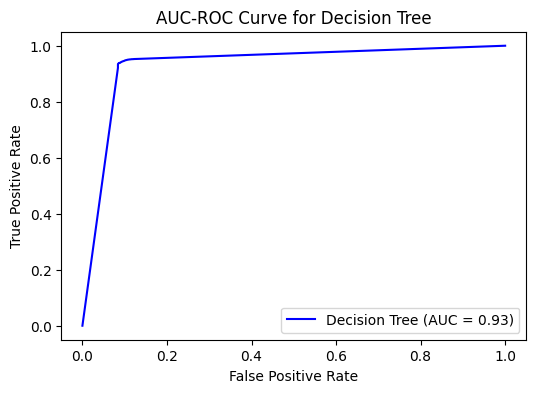

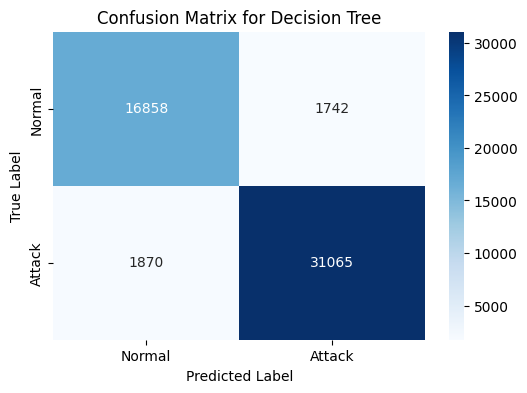


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18600
           1       0.96      0.95      0.95     32935

    accuracy                           0.94     51535
   macro avg       0.94      0.94      0.94     51535
weighted avg       0.94      0.94      0.94     51535

AUC-ROC for Random Forest: 0.99


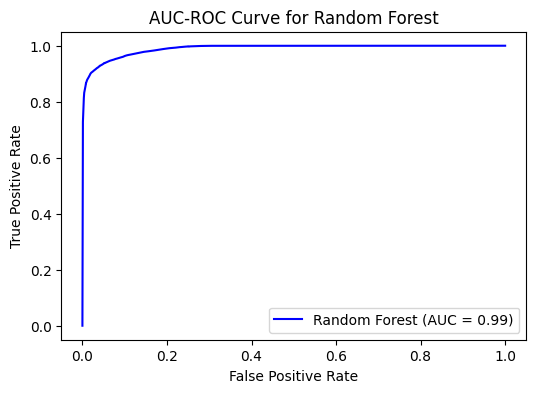

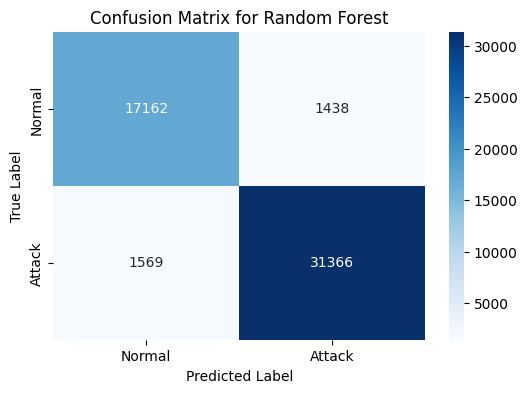


Classification Report for Neural Network:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     18600
           1       0.94      0.94      0.94     32935

    accuracy                           0.92     51535
   macro avg       0.92      0.91      0.92     51535
weighted avg       0.92      0.92      0.92     51535

AUC-ROC for Neural Network: 0.98


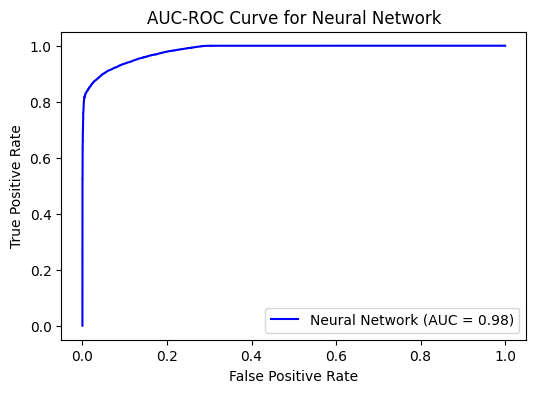

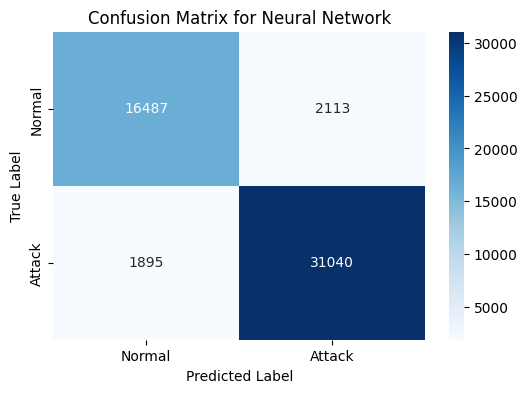

In [43]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)

    # Classification Report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # AUC-ROC Curve
    if hasattr(model, "predict_proba"):  # Check if model supports probability prediction
        y_prob = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_prob)
        print(f"AUC-ROC for {model_name}: {auc_score:.2f}")

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})", color="blue")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"AUC-ROC Curve for {model_name}")
        plt.legend()
        plt.show()

    # Confusion Matrix (Heatmap)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Evaluate all models
evaluate_model(dt_model, X_test_scaled, y_test, "Decision Tree")
evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
evaluate_model(nn_model, X_test_scaled, y_test, "Neural Network")


Original Class Distribution:
 label
1    164673
0     93000
Name: count, dtype: int64


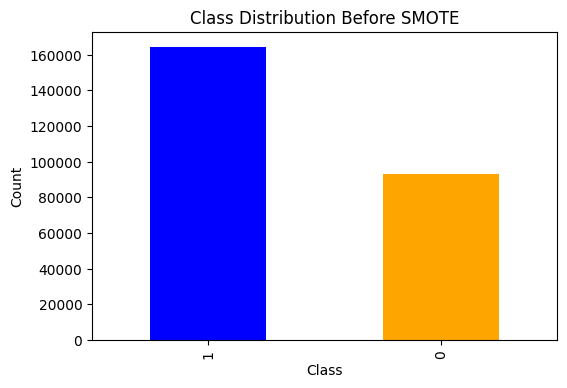

In [44]:
print("Original Class Distribution:\n", pd.Series(y).value_counts())

# Plot Class Distribution Before SMOTE
plt.figure(figsize=(6, 4))
pd.Series(y).value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc

def custom_smote(X, y, minority_class, k_neighbors=5, sampling_rate=1.0):
    """
    Custom SMOTE (Synthetic Minority Over-sampling Technique) implementation
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input feature matrix
    y : array-like of shape (n_samples,)
        Target values
    minority_class : any
        The class to be over-sampled
    k_neighbors : int, default=5
        Number of nearest neighbors to use
    sampling_rate : float, default=1.0
        Ratio of synthetic samples to generate
    
    Returns:
    --------
    X_resampled : array of shape (n_samples_new, n_features)
        Resampled training data
    y_resampled : array of shape (n_samples_new,)
        Resampled target values
    """
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Identify minority class samples
    minority_indices = np.where(y == minority_class)[0]
    minority_samples = X[minority_indices]
    
    # Calculate number of synthetic samples to generate
    n_minority = len(minority_samples)
    n_synthetic = int(n_minority * sampling_rate)
    
    # Fit nearest neighbors on minority class samples
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(minority_samples)
    
    # Generate synthetic samples
    synthetic_samples = []
    synthetic_labels = []
    
    for _ in range(n_synthetic):
        # Randomly select a minority sample
        sample_idx = np.random.randint(0, n_minority)
        sample = minority_samples[sample_idx]
        
        # Find k-nearest neighbors
        distances, indices = nn.kneighbors([sample])
        
        # Randomly select a neighbor (excluding the sample itself)
        neighbor_idx = np.random.randint(1, k_neighbors + 1)
        neighbor = minority_samples[indices[0, neighbor_idx]]
        
        # Interpolate to create synthetic sample
        alpha = np.random.random()
        synthetic_sample = sample + alpha * (neighbor - sample)
        
        synthetic_samples.append(synthetic_sample)
        synthetic_labels.append(minority_class)
    
    # Combine original and synthetic data
    X_resampled = np.vstack([X, synthetic_samples])
    y_resampled = np.hstack([y, synthetic_labels])
    
    return X_resampled, y_resampled

def custom_adasyn(X, y, minority_class, k_neighbors=5, sampling_rate=1.0):
    """
    Custom ADASYN (Adaptive Synthetic Sampling) implementation
    
    Parameters are similar to custom_smote
    """
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Identify minority and majority class samples
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y != minority_class)[0]
    
    minority_samples = X[minority_indices]
    majority_samples = X[majority_indices]
    
    # Fit nearest neighbors for minority samples
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(X)
    
    # Calculate distribution of difficult-to-learn samples
    distances, indices = nn.kneighbors(minority_samples)
    
    # Check neighbors' class distribution
    sample_difficulties = []
    for i, sample in enumerate(minority_samples):
        neighbor_classes = y[indices[i, 1:]]
        difficulty = np.mean(neighbor_classes != minority_class)
        sample_difficulties.append(difficulty)
    
    # Normalize difficulties to use as sampling weights
    sample_weights = np.array(sample_difficulties) / np.sum(sample_difficulties)
    
    # Calculate number of synthetic samples
    n_minority = len(minority_samples)
    n_synthetic = int(n_minority * sampling_rate)
    
    # Generate synthetic samples
    synthetic_samples = []
    synthetic_labels = []
    
    for _ in range(n_synthetic):
        # Weighted random selection of minority sample
        sample_idx = np.random.choice(len(minority_samples), p=sample_weights)
        sample = minority_samples[sample_idx]
        
        # Find k-nearest neighbors
        distances, indices = nn.kneighbors([sample])
        
        # Randomly select a neighbor from different class
        different_class_neighbors = [
            idx for idx in indices[0, 1:] 
            if y[idx] != minority_class
        ]
        
        if different_class_neighbors:
            neighbor_idx = np.random.choice(different_class_neighbors)
            neighbor = X[neighbor_idx]
            
            # Interpolate
            alpha = np.random.random()
            synthetic_sample = sample + alpha * (neighbor - sample)
            
            synthetic_samples.append(synthetic_sample)
            synthetic_labels.append(minority_class)
    
    # Combine original and synthetic data
    X_resampled = np.vstack([X, synthetic_samples])
    y_resampled = np.hstack([y, synthetic_labels])
    
    return X_resampled, y_resampled

# Prepare for ROC curve comparison
plt.figure(figsize=(10, 8))

# Original models
models_original = [
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model),
    ('Neural Network', nn_model)
]

# SMOTE models
X_smote, y_smote = custom_smote(X_train, y_train, minority_class=1, sampling_rate=1.0)
dt_smote = DecisionTreeClassifier(random_state=42)
rf_smote = RandomForestClassifier(random_state=42)
nn_smote = MLPClassifier(random_state=42)

dt_smote.fit(X_smote, y_smote)
rf_smote.fit(X_smote, y_smote)
nn_smote.fit(X_smote, y_smote)

models_smote = [
    ('Decision Tree (SMOTE)', dt_smote),
    ('Random Forest (SMOTE)', rf_smote),
    ('Neural Network (SMOTE)', nn_smote)
]

# ADASYN models
X_adasyn, y_adasyn = custom_adasyn(X_train, y_train, minority_class=1, sampling_rate=1.0)
dt_adasyn = DecisionTreeClassifier(random_state=42)
rf_adasyn = RandomForestClassifier(random_state=42)
nn_adasyn = MLPClassifier(random_state=42)

dt_adasyn.fit(X_adasyn, y_adasyn)
rf_adasyn.fit(X_adasyn, y_adasyn)
nn_adasyn.fit(X_adasyn, y_adasyn)

models_adasyn = [
    ('Decision Tree (ADASYN)', dt_adasyn),
    ('Random Forest (ADASYN)', rf_adasyn),
    ('Neural Network (ADASYN)', nn_adasyn)
]

# Plotting ROC curves for all models
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']

# Plot original models
for (name, model), color in zip(models_original, colors[:3]):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, 
                 label=f'{name} (AUC = {roc_auc:.2f})', 
                 linestyle='-')

# Plot SMOTE models
for (name, model), color in zip(models_smote, colors[3:6]):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, 
                 label=f'{name} (AUC = {roc_auc:.2f})', 
                 linestyle='--')

# Plot ADASYN models
for (name, model), color in zip(models_adasyn, colors[6:9]):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, 
                 label=f'{name} (AUC = {roc_auc:.2f})', 
                 linestyle=':')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Define Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Outputs between -1 and 1
        )
    
    def forward(self, z):
        return self.model(z)

# Define Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Outputs probability
        )
    
    def forward(self, x):
        return self.model(x)


In [ ]:
# Hyperparameters
input_dim = X.shape[1]
latent_dim = 20  # Size of random noise vector
epochs = 5000
batch_size = 64
lr = 0.00005

# Initialize models
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)  # Reduce Generator LR
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0003)  # Increase Discriminator LR

# Loss function
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

# Training loop
losses_g, losses_d = [], []

for epoch in range(epochs):
    # Train Discriminator
    real_samples = X_tensor[torch.randint(0, X_tensor.size(0), (batch_size,))]
    real_labels = torch.ones(batch_size, 1) 

    noise = torch.randn(batch_size, latent_dim)
    fake_samples = generator(noise)
    fake_labels = torch.zeros(batch_size, 1) 
    

    d_optimizer.zero_grad()
    real_loss = loss_fn(discriminator(real_samples), real_labels)
    fake_loss = loss_fn(discriminator(fake_samples.detach()), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()
    fake_labels = torch.ones(batch_size, 1)  # Trick discriminator
    g_loss = loss_fn(discriminator(fake_samples), fake_labels)
    g_loss.backward()
    g_optimizer.step()

    # Track loss
    losses_g.append(g_loss.item())
    losses_d.append(d_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")


Epoch 0: Generator Loss: 0.6849507093429565, Discriminator Loss: 1.381331205368042
Epoch 500: Generator Loss: 3.558541774749756, Discriminator Loss: 0.03425003960728645
Epoch 1000: Generator Loss: 5.832658290863037, Discriminator Loss: 0.019156470894813538
Epoch 1500: Generator Loss: 6.0563578605651855, Discriminator Loss: 0.012261806055903435
Epoch 2000: Generator Loss: 6.360339164733887, Discriminator Loss: 0.006162125151604414
Epoch 2500: Generator Loss: 5.78621244430542, Discriminator Loss: 0.014564398676156998
Epoch 3000: Generator Loss: 6.434186935424805, Discriminator Loss: 0.004979880526661873
Epoch 3500: Generator Loss: 7.300943374633789, Discriminator Loss: 0.0026879035867750645
Epoch 4000: Generator Loss: 6.922233581542969, Discriminator Loss: 0.002054438227787614
Epoch 4500: Generator Loss: 7.523108005523682, Discriminator Loss: 0.0032088803127408028


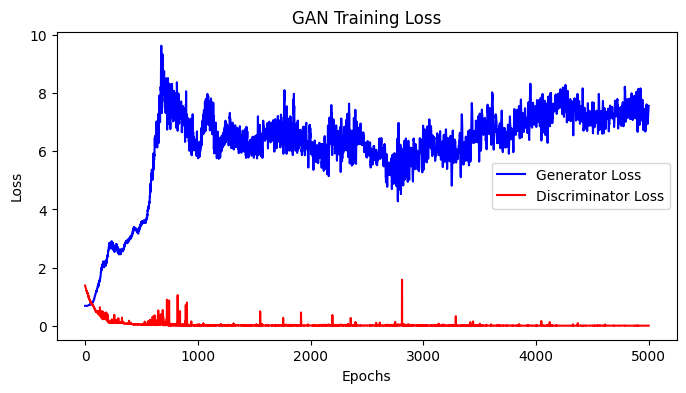

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(losses_g, label="Generator Loss", color="blue")
plt.plot(losses_d, label="Discriminator Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()


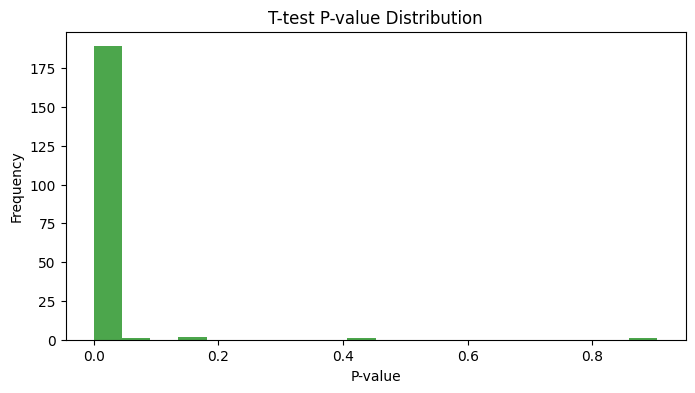

Mean P-value: 0.008836329210999727


In [ ]:
from scipy.stats import ttest_ind

# Generate synthetic samples
num_samples = X.shape[0]
noise = torch.randn(num_samples, latent_dim)
synthetic_samples = generator(noise).detach().numpy()

# Inverse transform synthetic samples to original scale
synthetic_samples = scaler.inverse_transform(synthetic_samples)

# Perform T-test
t_stat, p_val = ttest_ind(X, synthetic_samples, equal_var=False)

# Plot T-test results
plt.figure(figsize=(8, 4))
plt.hist(p_val, bins=20, color="green", alpha=0.7)
plt.xlabel("P-value")
plt.ylabel("Frequency")
plt.title("T-test P-value Distribution")
plt.show()

# Print mean p-value
print("Mean P-value:", np.mean(p_val))


In [33]:
# Create Augmented Dataset
X_augmented = np.vstack([X, synthetic_samples])
y_augmented = np.hstack([y, np.random.choice(y, size=len(synthetic_samples))])

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)

# Train Models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
nn_model = MLPClassifier(random_state=42, max_iter=300)

dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)


NameError: name 'RandomForestClassifier' is not defined

In [ ]:
evaluate_model(dt_model, X_test, y_test, "Decision Tree (GAN)")
evaluate_model(rf_model, X_test, y_test, "Random Forest (GAN)")
evaluate_model(nn_model, X_test, y_test, "Neural Network (GAN)")
